In [1]:
#importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Sequential, models
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling
import numpy as np
import cv2

In [13]:
#initilize global variables
IMAGE_SIZE = 256
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 50

In [3]:
#import the data using tensorflow keras and image size is of 256 and we creating a batch of 32 
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
#checking classes
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

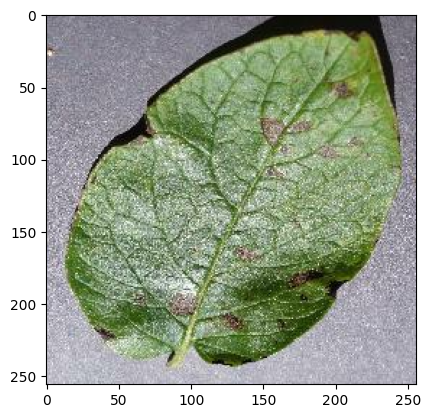

In [5]:
#displaying sample image from our dataset
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))

In [6]:
training_data = dataset.take(54)
testing_data = dataset.skip(54)
validation_data = testing_data.take(6)
testing_data = testing_data.skip(6)

In [7]:
def get_dataset_partitions_tf(ds,train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size  = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
#read the image from the disk
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
#model training using gamma correction when reduce layers 
#############################################################
input_shape  = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),  # Global average pooling instead of Flatten
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

model.build(input_shape = input_shape)

In [11]:
#model optimization using adam
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    
)

In [ ]:
#train the actual model and fit the data into the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 123s 2s/step - loss: 4.5297 - accuracy: 0.5654 - val_loss: 0.6831 - val_accuracy: 0.7292
Epoch 2/50
54/54 [==============================] - 131s 2s/step - loss: 0.5077 - accuracy: 0.7772 - val_loss: 0.3025 - val_accuracy: 0.9062
Epoch 3/50
54/54 [==============================] - 140s 3s/step - loss: 0.3054 - accuracy: 0.8814 - val_loss: 0.2424 - val_accuracy: 0.9219
Epoch 4/50
54/54 [==============================] - 136s 3s/step - loss: 0.2674 - accuracy: 0.9016 - val_loss: 0.2074 - val_accuracy: 0.9271
Epoch 5/50
54/54 [==============================] - 160s 3s/step - loss: 0.1601 - accuracy: 0.9363 - val_loss: 0.1187 - val_accuracy: 0.9479
Epoch 6/50
54/54 [==============================] - 149s 3s/step - loss: 0.1473 - accuracy: 0.9485 - val_loss: 0.1011 - val_accuracy: 0.9688
Epoch 7/50
54/54 [==============================] - 145s 3s/step - loss: 0.1065 - accuracy: 0.9583 - val_loss: 0.0857 - val_accuracy: 0.9844
Epoch 8/50
54

In [19]:
score = model.evaluate(test_ds)

8/8 [==============================] - 5s 472ms/step - loss: 0.0628 - accuracy: 0.9805


In [21]:
score
#while using previous cnn architecture we will get accuracy around
#within 50 epoch : 96%
#while using latest cnn architecture with Flatten layer instead of globalpooling layer we will get accuracy around
#within 20 epoch : loss: 0.0799 - accuracy: 0.9844
#within 50 epoch : loss: 0.0296 - accuracy: 0.9961
#while using latest cnn architecture with globalpooling layer instead of flatten layer we will get accuracy around
#within 20 epoch : loss: 0.0702 - accuracy: 0.9805
#within 50 epoch : loss: 0.0035 - accuracy: 0.9961


#Accuracy while using vgg16(It will take a lot of time for per epoch so triaining in vgg16 is some how difficult to perform)
# within 20 epoch : Loss : 0.059735722839832306, Accuracy : 0.98828125

#Accuracy while using keras
# within 20 epoch : loss : 0.02470768801867962, Accuracy = 0.99609375

[0.0628259927034378, 0.98046875]

In [23]:
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [24]:
import pickle
with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

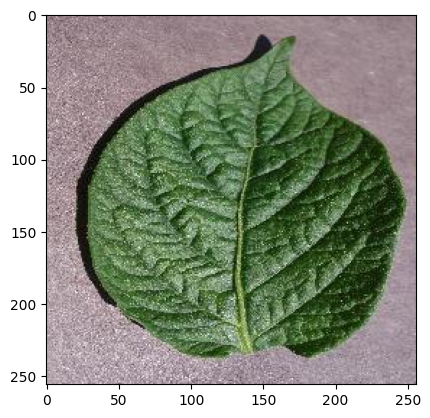

1/1 [==============================] - 0s 137ms/step
Predicted class: Potato___healthy
Predictions: [[5.2807288e-04 4.8629638e-02 9.5084226e-01]]


In [25]:
from tensorflow.keras.preprocessing import image
img_path = "C:\\Users\\lenovo\\Desktop\\potato disease classification\\python\\PlantVillage\\Potato___healthy\\00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG"
img = image.load_img(img_path, target_size=(256, 256))

# Display the image
plt.imshow(img)
plt.show()

# Preprocess the image for prediction
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Make predictions with the loaded model
predictions = loaded_model.predict(img_array)

# Get the predicted class and confidence
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]
print(f"Predicted class: {predicted_class}")
print("Predictions:", predictions)

In [47]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [48]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [49]:
len(history.history["accuracy"])

20

In [50]:
#ploting graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss  = history.history['val_loss']

Text(0.5, 1.0, 'Training and validation accuracy')

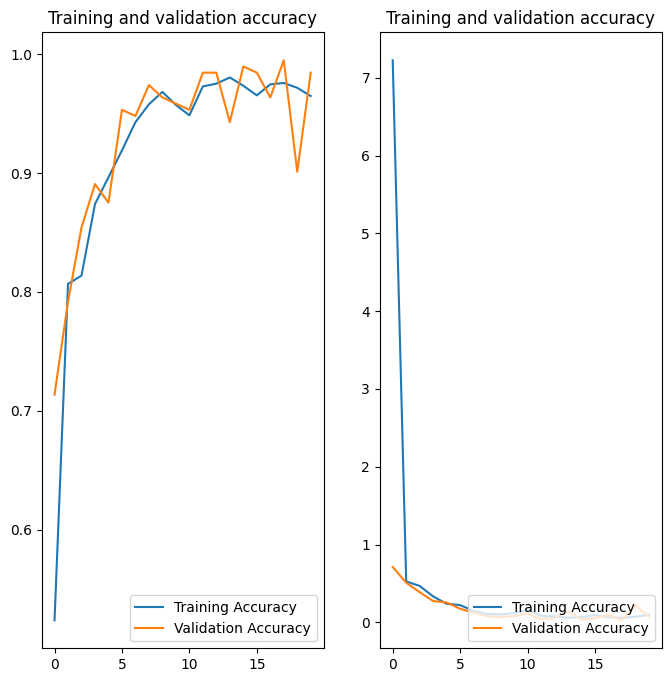

In [51]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc , label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss , label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_loss, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

first image to predict
my first label:  Potato___Early_blight
1/1 [==============================] - 0s 377ms/step
predicted label: Potato___Early_blight


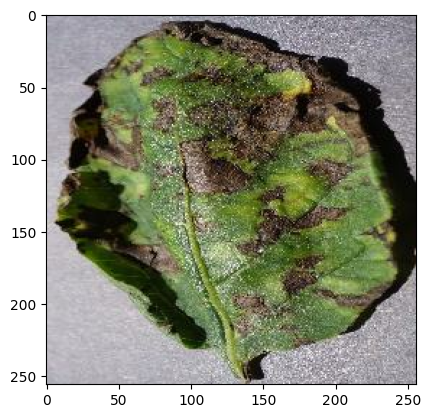

In [53]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print("my first label: ",class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [54]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)#create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 42ms/step


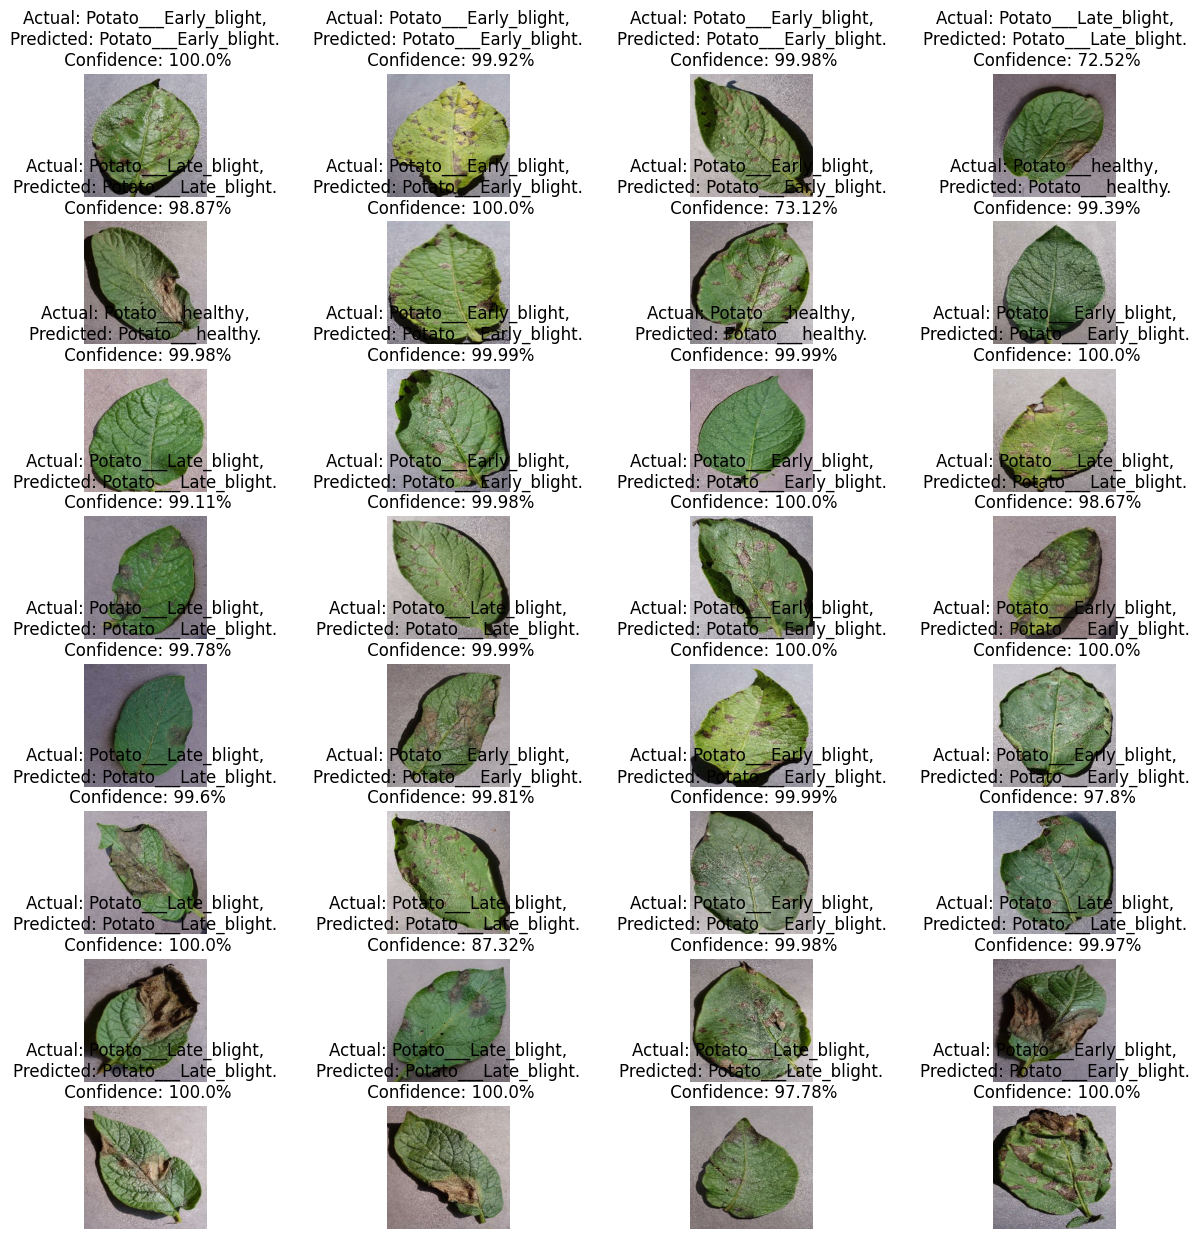

In [55]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(32):
        ax = plt.subplot(8,4,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis('off')

In [ ]:
##here we implement VGG16 using keras

In [19]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
input_size = [256,256,3]

In [20]:
vgg = VGG16(input_shape=input_size,weights='imagenet',include_top=False)
vgg.output

<KerasTensor: shape=(None, 8, 8, 512) dtype=float32 (created by layer 'block5_pool')>

In [21]:
for layer in vgg.layers:
    layer.trainable = False

In [22]:
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=3)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=3)))
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, depth=3)))

In [23]:
EPOCHS = 20

In [24]:
x = Flatten()(vgg.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)  # NUM_CLASSES is the number of output classes
model_vgg = Model(inputs=vgg.input, outputs=predictions)
model_vgg.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model_vgg.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/20
54/54 [==============================] - 388s 7s/step - loss: 3.8045 - accuracy: 0.8652 - val_loss: 0.4810 - val_accuracy: 0.9427
Epoch 2/20
54/54 [==============================] - 432s 8s/step - loss: 0.5009 - accuracy: 0.9635 - val_loss: 0.3664 - val_accuracy: 0.9583
Epoch 3/20
54/54 [==============================] - 466s 9s/step - loss: 0.3325 - accuracy: 0.9740 - val_loss: 0.4826 - val_accuracy: 0.9844
Epoch 4/20
54/54 [==============================] - 451s 8s/step - loss: 0.2674 - accuracy: 0.9763 - val_loss: 0.2779 - val_accuracy: 0.9792
Epoch 5/20
54/54 [==============================] - 562s 10s/step - loss: 0.0799 - accuracy: 0.9931 - val_loss: 0.1609 - val_accuracy: 0.9844
Epoch 6/20
54/54 [==============================] - 488s 9s/step - loss: 0.1163 - accuracy: 0.9878 - val_loss: 0.4141 - val_accuracy: 0.9792
Epoch 7/20
54/54 [==============================] - 418s 8s/step - loss: 0.1590 - accuracy: 0.9861 - val_loss: 0.1786 - val_accuracy: 0.9896
Epoch 8/20
5

In [25]:
score = model_vgg.evaluate(test_ds)
score

8/8 [==============================] - 58s 7s/step - loss: 0.3065 - accuracy: 0.9883


[0.30646654963493347, 0.98828125]

In [54]:
#train restnet

In [55]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [56]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [57]:
for layer in base_model.layers:
    layer.trainable = False

In [58]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # NUM_CLASSES is the number of classes in your dataset
model_restnet = Model(inputs=base_model.input, outputs=predictions)

In [59]:
model_restnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_restnet.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/20
 2/54 [>.............................] - ETA: 2:06 - loss: 3.0332 - accuracy: 0.2031

KeyboardInterrupt: 

In [ ]:
score = model_restnet.evaluate(test_ds)
score

In [ ]:
history

In [4]:
import os
save_dir_model1 = '/potato disease classification/'
os.makedirs(save_dir_model1, exist_ok=True)
model_restnet.save(os.path.join(save_dir_model1, 'model3'))

NameError: name 'model_restnet' is not defined

In [5]:
from tensorflow.keras.models import load_model

loaded_model = load_model('/potato disease classification/model1')

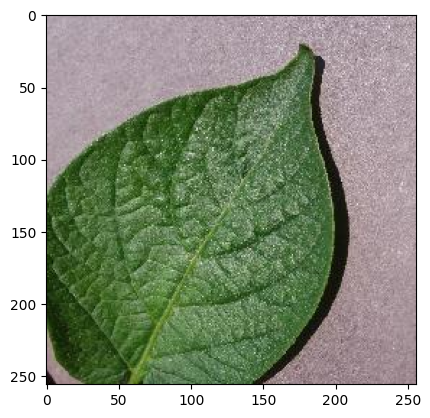

In [15]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
img_path = 'C:\\Users\\lenovo\\Desktop\\potato disease classification\\imag.JPG'
img = image.load_img(img_path, target_size=(256, 256))
plt.imshow(img)
plt.show()
CLASS_NAMES = ['early','healthy','late']

In [17]:
# Preprocess the image for prediction
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
processed_img = img_array / 255.0  # Assuming normalization

# Make predictions with the loaded model
predictions = loaded_model.predict(processed_img)

# Assuming CLASS_NAMES is a list of class names for your model
# Get the predicted class and confidence
predicted_class_index = np.argmax(predictions)
predicted_class = CLASS_NAMES[predicted_class_index]
predicted_class


1/1 [==============================] - 0s 39ms/step


'early'